In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage.filters import convolve1d
import itertools


   

In [2]:
import matplotlib as mpl

plt.style.use('seaborn-whitegrid')

mpl.rcParams['grid.linestyle'] = ':'   

mpl.rcParams['figure.figsize'] = [20.0, 20.0]
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['savefig.dpi'] = 400

mpl.rcParams['font.size'] = 14
mpl.rcParams['font.style'] = 'oblique'
mpl.rcParams['font.weight']= 'heavy'



mpl.rcParams['figure.titlesize'] = 'large'
mpl.rcParams['figure.titleweight'] = 'heavy'

mpl.rcParams['axes.labelsize'] = 'large'
mpl.rcParams['axes.labelweight'] = 'heavy'
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.titleweight'] = 'heavy'


mpl.rcParams['legend.fancybox'] = False
mpl.rcParams['legend.fontsize'] = 'medium'
mpl.rcParams['legend.frameon'] = True
mpl.rcParams['legend.framealpha'] = 50
mpl.rcParams['legend.facecolor'] = 'inherit'
mpl.rcParams['legend.edgecolor'] = '0.8'

In [3]:

############################################################
#                  Simulation parameter                    #
############################################################

# Define initial condition (not necessary?)
#x0 = 0

# Time step
dt = 0.001 # -> 1ms

# Solve differential equation from time 0 to time T
T = 2.0

# Descretize time into equal steps
t = np . linspace (0 , T , int ( T / dt )+1)




In [4]:
############################################################
#                Network Inputs/Outputs                    #
############################################################

# define the inputs
# assuming we have 16 frquency bands
freq_bands = 5
s_gbc_all= np.zeros((len(t),freq_bands))
s_sbc_all = np.zeros((len(t),freq_bands))

# store the solutions
q_all = np.zeros((len(t),freq_bands))
r_all = np.zeros((len(t),freq_bands))




#define the kernels (assuming that they fold over 16 freq_bands)
# x =  np.linspace(0,freq_bands,freq_bands)
# cf = 8



In [5]:
############################################################
#                       Functions                          #
############################################################

#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    # build a threshold. make sure we do not change the original array (called by reference)
    if isinstance(r_bpc, (list,np.ndarray)):
        tmp = 1.0*r_bpc
        tmp[tmp < 0.00] = 0.0
    else:
        if r_bpc < 0.00:
            tmp = 0.0
        else:
            tmp = r_bpc
    
    return 1 / (1 + np.exp(-(tmp-b)*a) )
# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    q_pc[q_pc < 0.000] = 0.0
    return np.maximum(q_pc,0)
#     return 1 / (1 + np.exp(-(q_pc-0.5)*8) )
# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel))
            
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    return tau_r * d_r_bpc


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return tau_q * d_q_pc

# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p


In [6]:



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 40.0
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 2.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 40.0
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0

## Stimuli Level Influence on LSP Response

In [7]:




# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0

# Parameter to test
num_input_trials =8

sbc_input_intensities = np.array([0.0,0.07,0.17,0.27,0.37,0.47,0.57,0.87])
gbc_input_intensities = np.array([0.0,0.07,0.17,0.27,0.37,0.47,0.57,0.87])


# store values for different parameters
q_all = np.zeros((num_input_trials,len(t),freq_bands))
r_all = np.zeros((num_input_trials,len(t),freq_bands))
############################################################
#                      Simulation                          #
############################################################
# for gamma_r in [0.0,1.0,5.0]:
#     for kappa_r in [0.0,1.0,5.0]:
for k in range(0,num_input_trials):
    
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    sigma = 1.25

    # MNTB inhibitory input (contra-lateral)
    gbc_input_onset = 400
    gbc_input_duration = 500
    gbc_center_frequencyBand = 3
    gbc_input_strength = 2.0
    # create a linearly decreasing function in frequency band 'center_frequencyband'
    # and smear it with a gauss to effect the neighboring bands
    gbc_gauss_mask = gauss(np.arange(freq_bands),gbc_center_frequencyBand,sigma)
    # build a plateau at the end to let the neurons go to a steady state
    s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
    # create the decreasing function
    dec_func = np.zeros((len(t),))
    dec_func[0:400] = 0.0
    dec_func[400:800] = 0.2
    dec_func[800:1200] = 0.4
    dec_func[1200:1600] = 0.6
    dec_func[1600:2000] = 0.8
    
    # add axis so that we acutally have array of (n,m) and not just (n,)
    gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
    dec_func = dec_func[np.newaxis]
    s_gbc_all =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength
    
    gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')


    # LSO direct excitatory input (ipsi-lateral)
    sbc_input_onset = 0
    sbc_input_duration = 500
    sbc_center_frequencyBand = 3
    sbc_input_strength = 1.0
    sbc_gauss_mask = gauss(np.arange(freq_bands),sbc_center_frequencyBand,sigma)
    s_sbc_all[sbc_input_onset-100:sbc_input_onset] = sbc_input_strength * sbc_gauss_mask
    s_sbc_all[sbc_input_onset:-100] = sbc_gauss_mask * sbc_input_strength

    sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')
    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi



    s_sbc_all *= sbc_input_intensities[k]
    s_gbc_all *= gbc_input_intensities[k]





    
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):
            # E-E kernel
            ee_kernel = gauss(np.arange(freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel,spf_r)       
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            

#     fig = plt.figure(figsize=(20,15))

#     stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
#     plt.suptitle(stri,fontsize=16)

#     ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
#     plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
#     plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')


# plt.show()


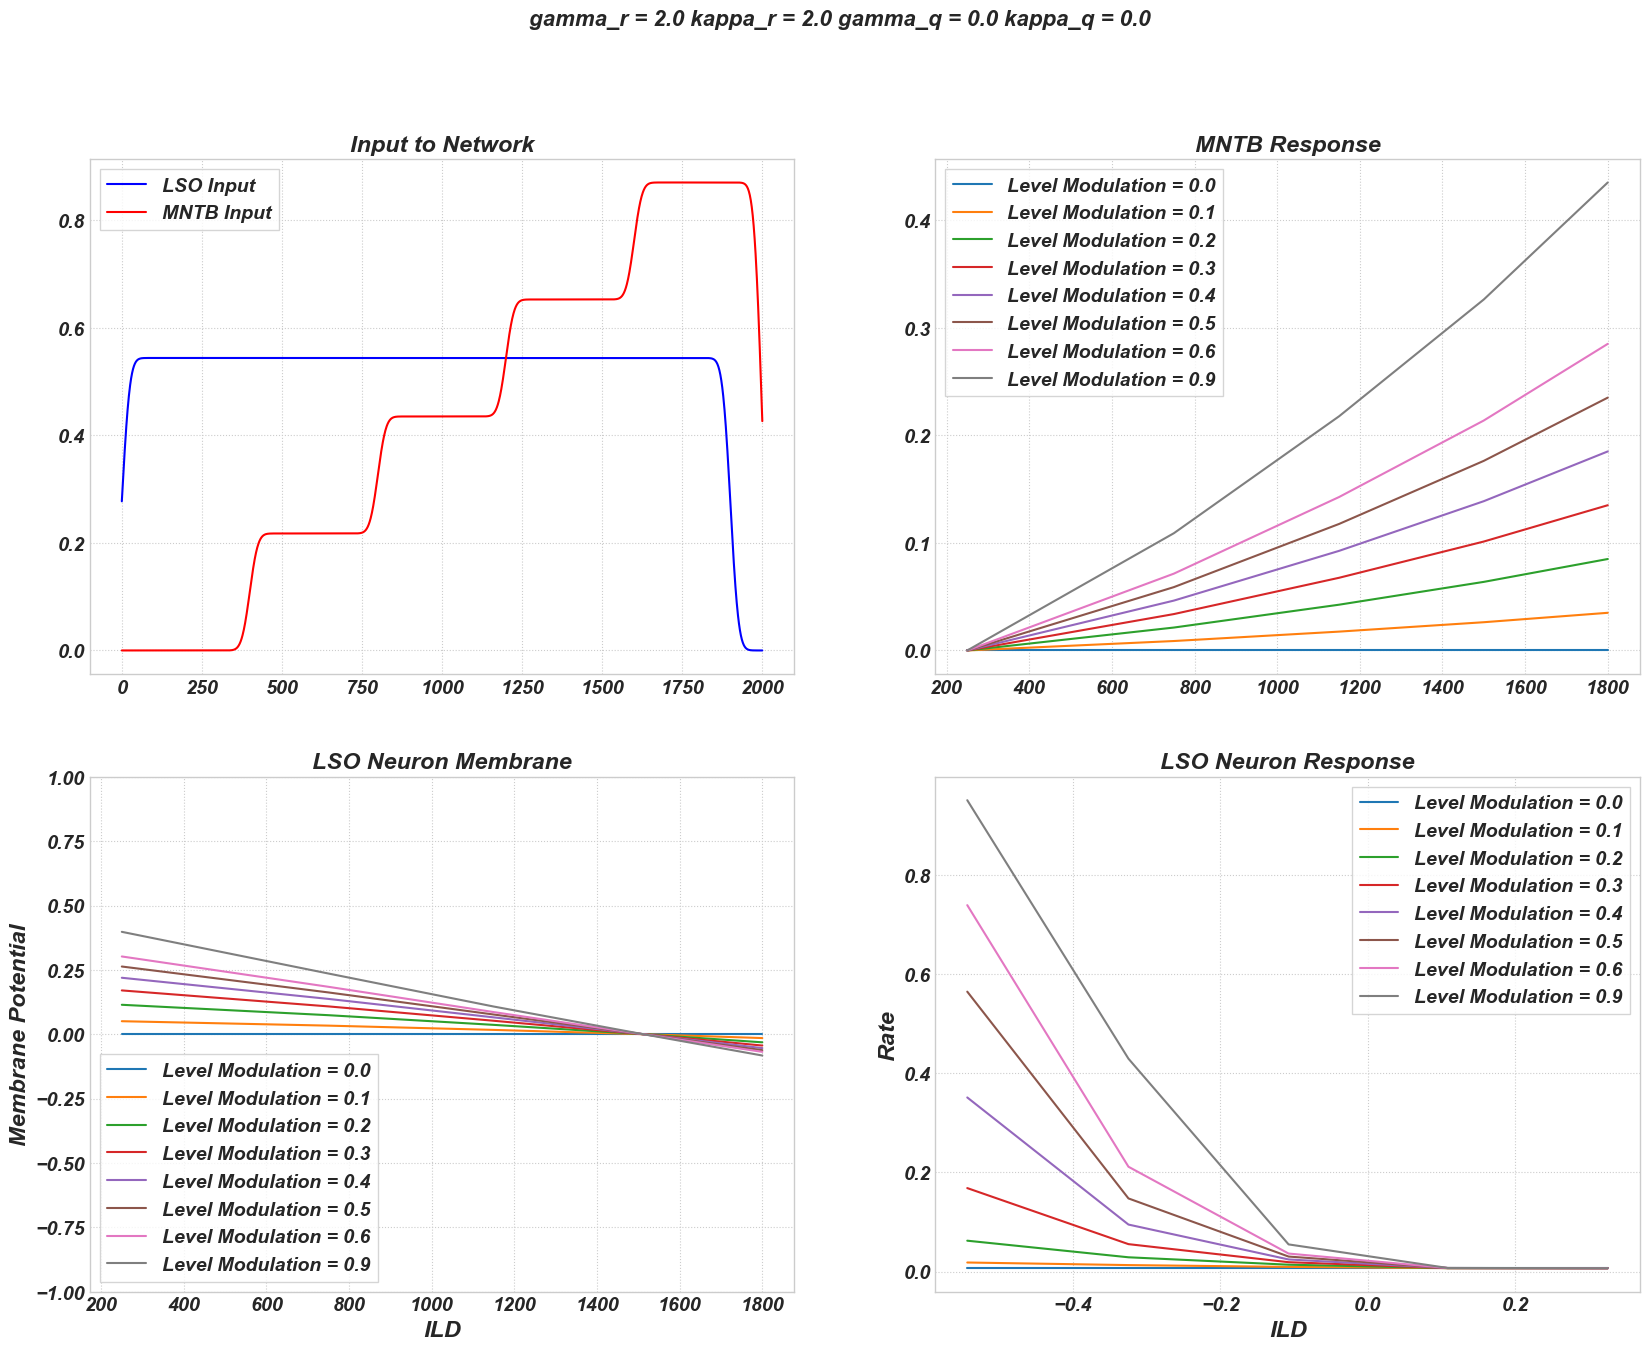

In [8]:
# Define the times when to probe
probing_times = [250,750,1150,1500,1800]



fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=1)
plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
plt.title('Input to Network')
plt.legend()

ax1 = plt.subplot2grid((2, 2), (0, 1), colspan=1)
q = q_all[:,:,3]
for i in range(0,q.shape[0]):
    plt.plot(probing_times,q[i,probing_times],label='Level Modulation = {0:.1f}'.format(sbc_input_intensities[i]))
plt.title('MNTB Response')
plt.legend()

# show LSO neuron membrane
diff_input =  s_gbc_all-s_sbc_all
diff_input = diff_input[:,3]
r = r_all[:,:,3]
ax2 = plt.subplot2grid((2, 2), (1, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(probing_times,r[i,probing_times],label='Level Modulation = {0:.1f}'.format(sbc_input_intensities[i]))
plt.title('LSO Neuron Membrane')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(diff_input[probing_times],g_r_out(r[i,probing_times]),label='Level Modulation = {0:.1f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Rate')
plt.legend()
# plt.ylim([0,1])


plt.show()



Above cell shows same point of inhibition for different stimuli ranges.

If we would like to shift that point from here ~-0.1 ILD to another one we need to adapte the threshold (for g_r_out) and inhibition (gamma_r and kappa_r). __Maybe also threshold for g_q_out__. 

## Ipsilateral Excitation (as in Parker et al . 1997)

In [9]:




# Parameter to test
num_input_trials = 7

sbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57])

# store values for different parameters
q_all = np.zeros((num_input_trials,len(t),freq_bands))
r_all = np.zeros((num_input_trials,len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[:,0,:] = 0.0
############################################################
#                      Simulation                          #
############################################################
for k in range(num_input_trials):
    
    ############################################################
    #                       Inputs                             #
    ############################################################
    s_gbc_all= np.zeros((len(t),freq_bands))
    s_sbc_all = np.zeros((len(t),freq_bands))

    # Define input signal in a plausible way (gaussian input signal over frequency bands?)
    
    # sigma for gauss over frequency bands
    sigma = 1.25

    # MNTB inhibitory input (contra-lateral)
#     gbc_input_onset = 200
#     gbc_input_duration = 500
#     gbc_center_frequencyBand = 3
#     gbc_input_strength = 2.0
#     # create a linearly decreasing function in frequency band 'center_frequencyband'
#     # and smear it with a gauss to effect the neighboring bands
#     gbc_gauss_mask = gauss(np.arange(0,freq_bands),gbc_center_frequencyBand,sigma)
#     # build a plateau at the end to let the neurons go to a steady state
#     s_gbc_all[-300:-100] =  gbc_input_strength * gbc_gauss_mask
#     # create the decreasing function
#     dec_func = np.linspace(0,1,len(s_gbc_all[gbc_input_onset:-300]))
#     # add axis so that we acutally have array of (n,m) and not just (n,)
#     gbc_gauss_mask = gbc_gauss_mask[np.newaxis].T
#     dec_func = dec_func[np.newaxis]
#     s_gbc_all[gbc_input_onset:-300] =  gbc_gauss_mask.dot(dec_func).T * gbc_input_strength


    # LSO direct excitatory input (ipsi-lateral)
    sbc_input_onset = 500
    sbc_input_duration = 500
    sbc_center_frequencyBand = 3
    sbc_input_strength = 1.0
    sbc_gauss_mask = gauss(np.arange(0,freq_bands),sbc_center_frequencyBand,sigma)
    # build a plateau at the beginning to let the neurons go to a steady state
    s_sbc_all[sbc_input_onset-100:sbc_input_onset] = sbc_input_strength * sbc_gauss_mask
    # build a plateau at the end to let the neurons go to a steady state
    s_sbc_all[sbc_input_onset:-500] = sbc_gauss_mask * sbc_input_strength

    sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
    s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

    # Convolve with gauss curve to build a temporal ramp
    s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
    s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

    # normalize 
    maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
    s_gbc_all /= maxi
    s_sbc_all /= maxi


    s_sbc_all *= sbc_input_intensities[k]





    
    for i in range(0, len(t)-1):
        for w in range(0,freq_bands):
            # E-E kernel
            ee_kernel = gauss(np.arange(freq_bands),w,0.5)
            ei_kernel = gauss(np.arange(freq_bands),w,0.1)
            ie_kernel = gauss(np.arange(freq_bands),w,0.1)
            ii_kernel = gauss(np.arange(freq_bands),w,1.0)

            # normalize it 
            ee_kernel /= np.max(ee_kernel)
            ei_kernel /= np.max(ie_kernel)
            ie_kernel /= np.max(ie_kernel)
            ii_kernel /= np.max(ie_kernel)
                
            # as an MNTB input we use the value of the previously calculated time step. 
            # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
            r_all[k,i+1,w] = r_all[k,i,w] +  dt * ode_r_bpc(r_all[k,i,w],s_sbc_all[i],ee_kernel,q_all[k,i,:],ei_kernel,spf_r)       
            q_all[k,i+1,w] = q_all[k,i,w] +  dt * ode_q_pc(q_all[k,i,w],s_gbc_all[i],ie_kernel,q_all[k,i,:],ii_kernel)
            







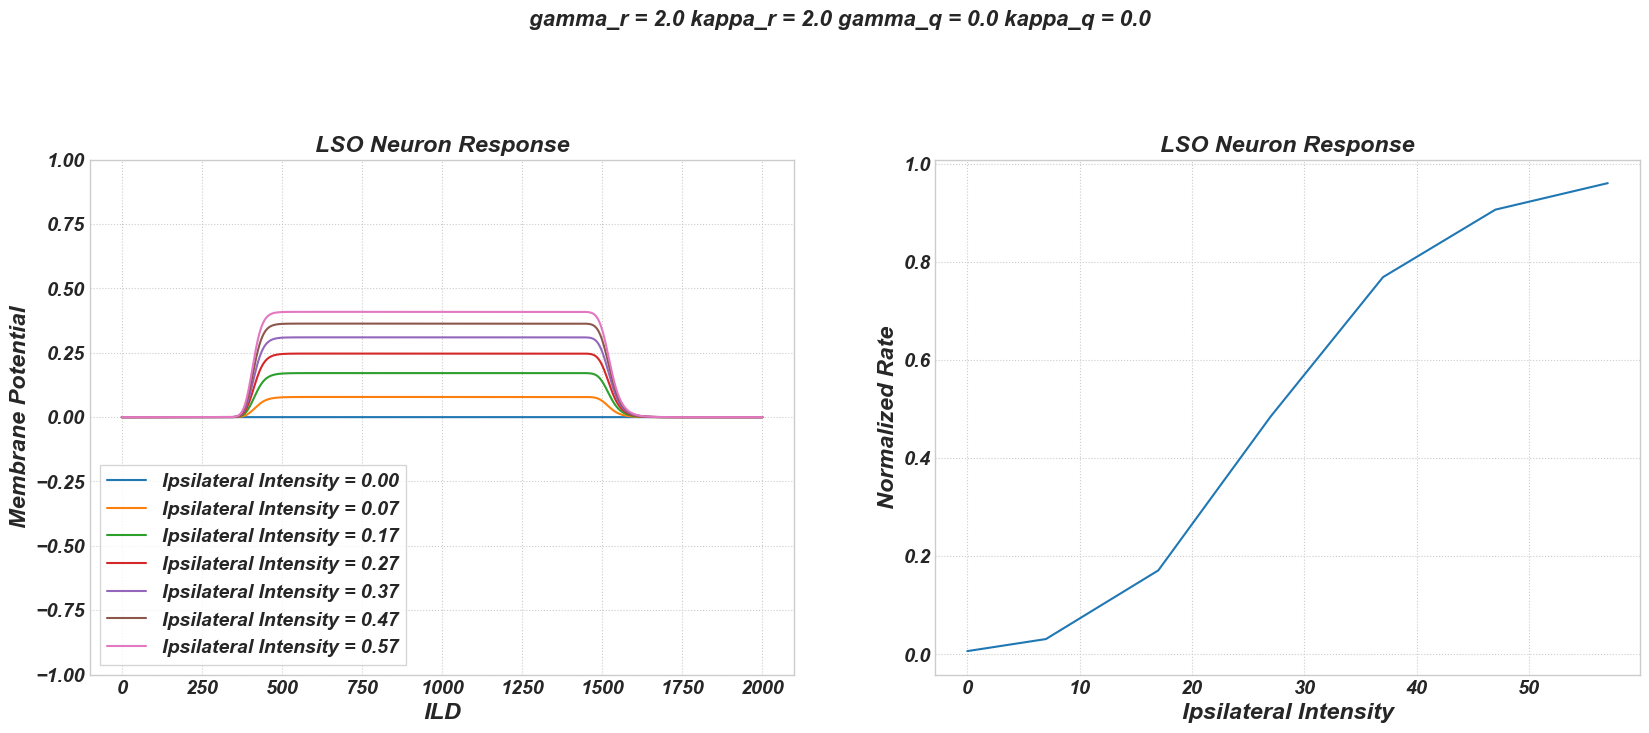

In [10]:
fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# plt.plot(s_sbc_all[:,8],'blue',  label='LSO Input')
# plt.plot(s_gbc_all[:,8],'red',  label='MNTB Input')
# plt.title('Input to Network')
# plt.legend()

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all

diff_input = diff_input[:,3]
r = r_all[:,:,3]
ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(r[i,:],label='Ipsilateral Intensity = {0:.2f}'.format(sbc_input_intensities[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)

plt.plot((sbc_input_intensities*100),g_r_out(r[:,800]))


# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('Ipsilateral Intensity')
plt.ylabel('Normalized Rate')
# plt.ylim([0,1])


plt.show()



## Contralateral Inhibition (as in Parker et. al 1997)

In [11]:


# Parameter to test
gbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57])
sbc_input_intensities = np.array([0.17,0.27,0.37,0.47,0.57])

# store values for different parameters
q_all = np.zeros((len(sbc_input_intensities),len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(sbc_input_intensities),len(gbc_input_intensities),len(t),freq_bands))

# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0
############################################################
#                      Simulation                          #
############################################################
for l in range(len(sbc_input_intensities)):
    for k in range(num_input_trials):
        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)

        # sigma for gauss over frequency bands
        sigma = 1.25

        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 500
        gbc_input_duration = 500
        gbc_center_frequencyBand = 3
        gbc_input_strength = 1.0
        gbc_gauss_mask = gauss(np.arange(freq_bands),gbc_center_frequencyBand,sigma)
        # build a plateau at the beginning to let the neurons go to a steady state
        s_gbc_all[gbc_input_onset-100:gbc_input_onset] = gbc_input_strength * gbc_gauss_mask
        # build a plateau at the end to let the neurons go to a steady state
        s_gbc_all[gbc_input_onset:-500] = gbc_gauss_mask * gbc_input_strength

        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_gbc_all = convolve1d(s_gbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 500
        sbc_input_duration = 500
        sbc_center_frequencyBand = 3
        sbc_input_strength = 1.0
        sbc_gauss_mask = gauss(np.arange(freq_bands),sbc_center_frequencyBand,sigma)
        # build a plateau at the beginning to let the neurons go to a steady state
        s_sbc_all[sbc_input_onset-100:sbc_input_onset] = sbc_input_strength * sbc_gauss_mask
        # build a plateau at the end to let the neurons go to a steady state
        s_sbc_all[sbc_input_onset:-500] = sbc_gauss_mask * sbc_input_strength

        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

        # Convolve with gauss curve to build a temporal ramp
        s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

        # normalize 
        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
        s_gbc_all /= maxi
        s_sbc_all /= maxi


        s_sbc_all *= sbc_input_intensities[l]
        s_gbc_all *= gbc_input_intensities[k]






        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r)       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r)       
                
                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)


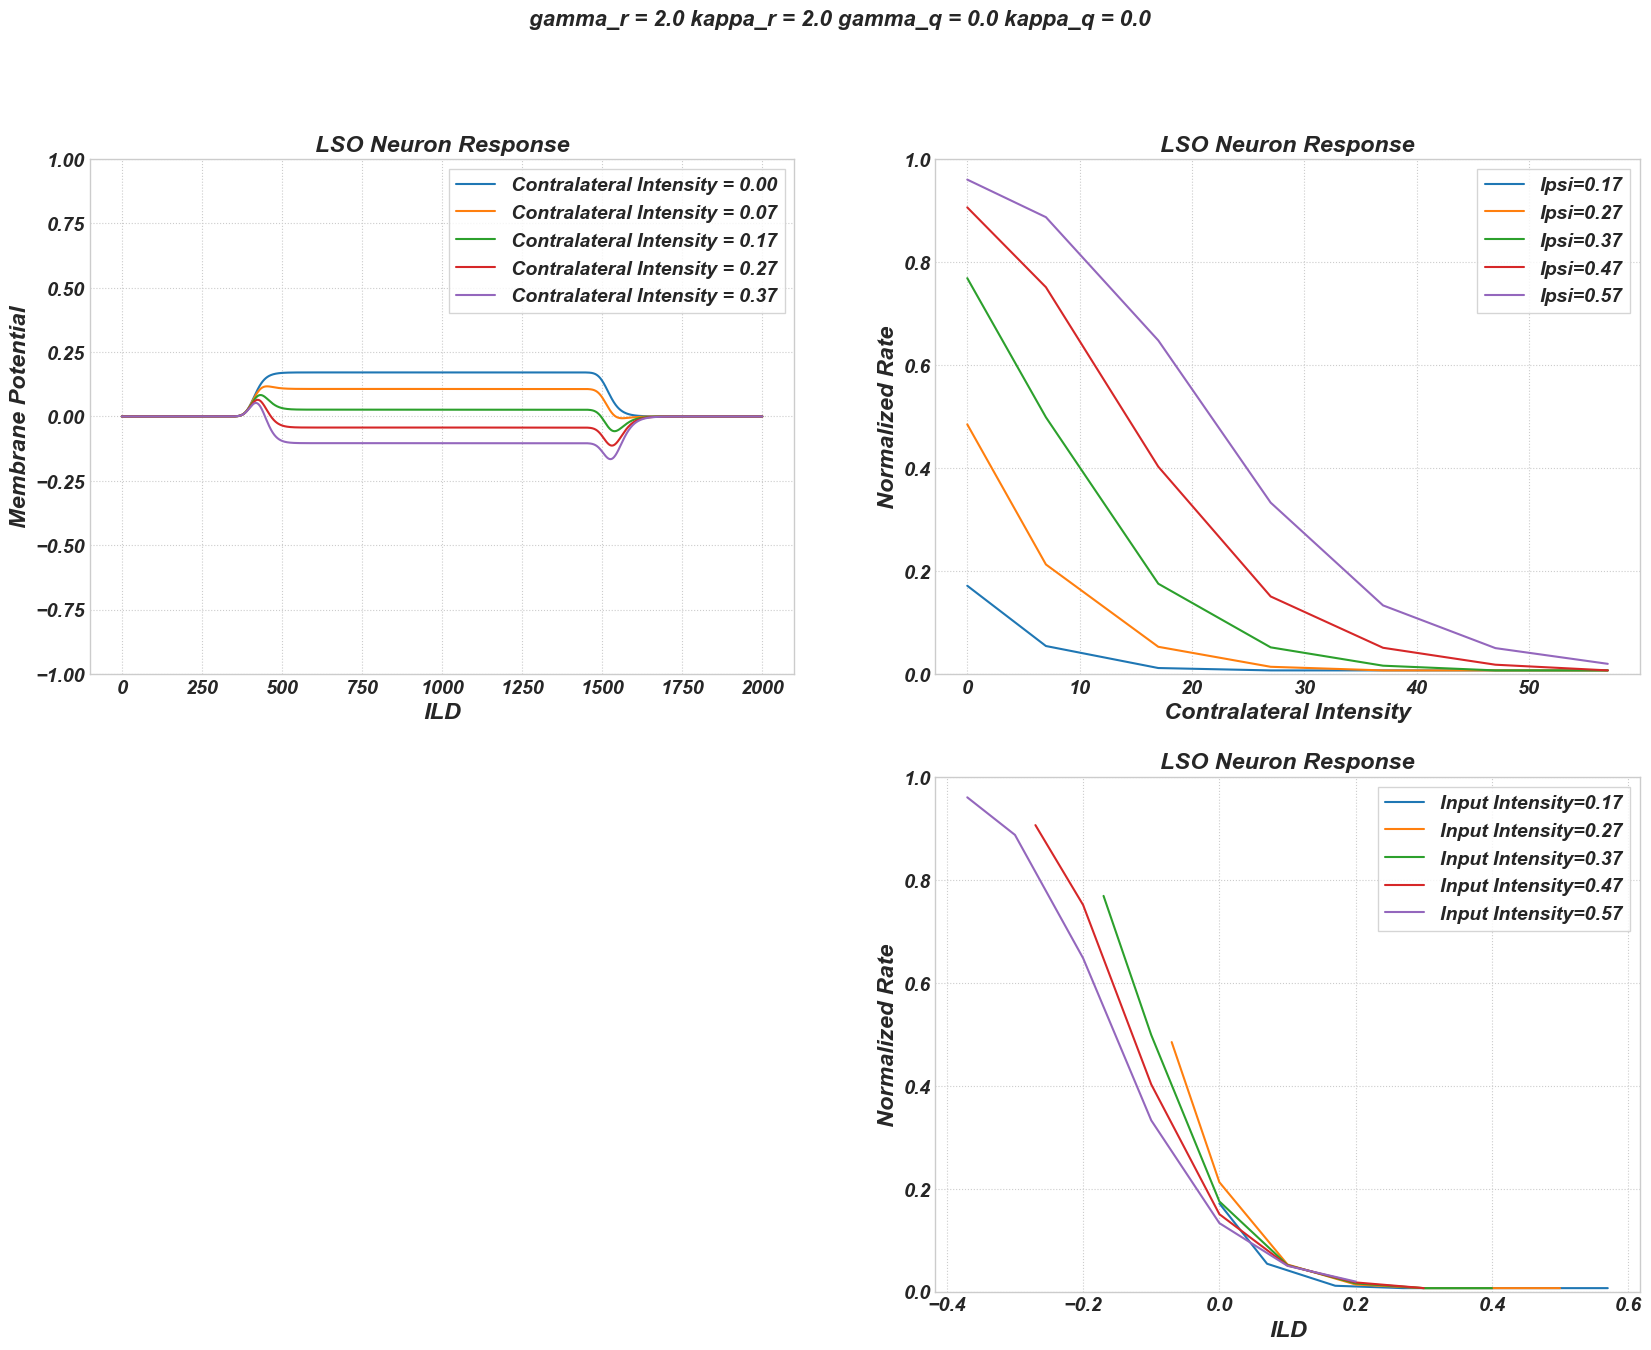

In [12]:
fig = plt.figure(figsize=(20,15))

stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
plt.suptitle(stri,fontsize=16)

# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# plt.plot(s_sbc_all[:,8],'blue',  label='LSO Input')
# plt.plot(s_gbc_all[:,8],'red',  label='MNTB Input')
# plt.title('Input to Network')
# plt.legend()


# q = q_all[:,:,3]
# ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(q[i,:],label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
# plt.title('MNTB Neuron Response')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])
# plt.legend()

# ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(g_q_out(q[i,:]),label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
# plt.title('MNTB Neuron Response')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])
# plt.legend()



# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all

diff_input = diff_input[:,3]
r = r_all[:,:,:,3]
ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(r[0,i,:],label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
plt.legend()
## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
for i in range(len(sbc_input_intensities)):
    plt.plot((gbc_input_intensities*100),g_r_out(r[i,:,800]),label='Ipsi={0:.2f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('Contralateral Intensity')
plt.ylabel('Normalized Rate')
plt.ylim([0,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
for i in range(len(sbc_input_intensities)):
    plt.plot((gbc_input_intensities-gbc_input_intensities[i]),g_r_out(r[i,:,800]),label='Input Intensity={0:.2f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Normalized Rate')
plt.ylim([0,1])
plt.legend()


plt.show()



## Same simulation as above but we use the full neuron model with inhibition and timing

In [13]:



############################################################
#                 BPC neuron parameter                     #
#  parameters for r_bpc neuron of LSO, all marked by a _r  #
############################################################
# tau defines how fast the membrane potential builds up
tau_r = 1/40
# alpha defines the decay rate of the membrane potential but also the value to which it saturates (implicitly)
alpha_r = 1.0
# beta defines the upper limit of the membrane potential
beta_r = 1.0
# gamma defines the subtractive influence of the inhibitory input
gamma_r = 2.0
# kappa defines the divisive influence of the inhibitory input
kappa_r = 4.0

############################################################
#                 PC neuron parameter                      #
#  parameters for q_pc neuron of MNTB, all marked by a _q  #
############################################################
tau_q = 1/40
alpha_q = 2.0 
beta_q = 1.0
gamma_q = 0.0
kappa_q = 0.0

############################################################
#                 GABA neuron parameter                    #
#  parameters for p_gaba inhibitory neuron of LSO, all marked by a _p #
############################################################
tau_p = 25
alpha_p = 10.0
beta_p = 10.0


In [14]:
############################################################
#                       Functions                          #
############################################################

#define a gauss function
def gauss(x,mean,sigma):
    if sigma == 0.0:
        return np.zeros(x.shape)
    else: 
        return np.exp(-(x-mean)**2 /( 2 * sigma**2 ))


# Defines the output transfer function of r_bpc
def g_r_out(r_bpc,a =20,b=0.25):
    # build a threshold. make sure we do not change the original array (called by reference)
    if isinstance(r_bpc, (list,np.ndarray)):
        tmp = 1.0*r_bpc
        tmp[tmp < 0.00] = 0.0
    else:
        if r_bpc < 0.00:
            tmp = 0.0
        else:
            tmp = r_bpc
    
    return 1 / (1 + np.exp(-(tmp-b)*a) )

# Defines the output transfer function of q_pc
def g_q_out(q_pc):
    ## Defines a threshold ?
    q_pc[q_pc < 0.000] = 0.0
    return np.maximum(q_pc,0)

# Defines the ODE for the r_bpc neuron
def ode_r_bpc(r_bpc,s_sbc,ee_kernel,q_pc,ei_kernel,bias,gaba_exc=0,gaba_inh=0):
    # get the globally defined parameters
    global tau_r ,alpha_r, beta_r, gamma_r, kappa_r

    # do a subtractive inhibition, this is done by subtracting the g_r_out values from the kernel weights
    # calculate excitatory input, which comes from the SBC cells folded by the E-E kernel

    
    ee_kernel  = ee_kernel*(1-gaba_exc)
    excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) # * 1/( gaba_exc+1.0) 
    # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
    ei_kernel  = ei_kernel*(1-gaba_inh)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel)) #* 1/(gaba_inh+1.0)       
    # calculate the change of r_bpc
    d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - ((gamma_r) + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
    
#     excitatory_in = np.sum(np.multiply(s_sbc,ee_kernel)) 1
#     # calculate inhibitor input, which comes from the q_pc folded by the I-E kernel
#     inhibitory_in = np.sum( np.multiply(g_q_out(q_pc),ei_kernel))     
#     # calculate the change of r_bpc
#     d_r_bpc = -alpha_r * r_bpc + (beta_r-r_bpc) * excitatory_in - (gamma_r + kappa_r * r_bpc) * inhibitory_in + bias*alpha_r
        
    return d_r_bpc / tau_r


# Defines the ODE for the q_pc neuron
def ode_q_pc(q_pc, s_gbc,ie_kernel,q_pc_all,ii_kernel):
    # get the globally defined parameters
    global tau_q,alpha_q,beta_q,gamma_q,kappa_q

    # calculate excitatory input, which comes from the GBC cells folded by the I-E kernel
    excitatory_in = np.sum(np.multiply(s_gbc,ie_kernel))
    # calculate inhibitor input, which comes from the q_pc folded by the I-I kernel (self-inhibition)
    inhibitory_in = np.sum( np.multiply(g_q_out(q_pc_all),ii_kernel))
    
    d_q_pc = -alpha_q * q_pc + beta_q * excitatory_in - (gamma_q + kappa_q * q_pc) * inhibitory_in 
    
    return  d_q_pc  / tau_r


# Defines the ODE for the p_gaba neuron which defines the strength of the modulation (inhibition) of the inputs of the r neuron
def ode_p_pc(p_gaba, r_gbc):
    # get the globally defined parameters
    global tau_p,alpha_p,beta_p

    d_p_pc =   -alpha_p*p_gaba +(beta_p - p_gaba)*g_r_out(r_gbc)  
    return  d_p_pc  / tau_p

In [15]:

# Parameter to test
gbc_input_intensities = np.array([0,0.07,0.17,0.27,0.37,0.47,0.57,0.67,0.77,0.87,0.97])
sbc_input_intensities = np.array([0.17,0.27,0.37,0.47,0.57,0.67,0.77,0.87,0.97])
# gbc_input_intensities = np.linspace(-0.25,1.0,10)


# store values for different parameters
q_all = np.zeros((len(sbc_input_intensities),len(gbc_input_intensities),len(t),freq_bands))
r_all = np.zeros((len(sbc_input_intensities),len(gbc_input_intensities),len(t),freq_bands))
p_all = np.zeros((len(sbc_input_intensities),len(gbc_input_intensities),len(t),freq_bands))





# define the spontaneous firing rate of neuron
spf_r = 0.0
r_all[0,:] = 0.0
############################################################
#                      Simulation                          #
############################################################
for l in range(len(sbc_input_intensities)):
    for k in range(len(gbc_input_intensities)):
        ############################################################
        #                       Inputs                             #
        ############################################################
        s_gbc_all= np.zeros((len(t),freq_bands))
        s_sbc_all = np.zeros((len(t),freq_bands))

        # Define input signal in a plausible way (gaussian input signal over frequency bands?)

        # sigma for gauss over frequency bands
        sigma = 1.25

        # MNTB inhibitory input (contra-lateral)
        gbc_input_onset = 500
        gbc_input_duration = 500
        gbc_center_frequencyBand = 3
        gbc_input_strength = 1.0
        gbc_gauss_mask = gauss(np.arange(freq_bands),gbc_center_frequencyBand,sigma)
        # build a plateau at the beginning to let the neurons go to a steady state
        s_gbc_all[gbc_input_onset-100:gbc_input_onset] = gbc_input_strength * gbc_gauss_mask
        # build a plateau at the end to let the neurons go to a steady state
        s_gbc_all[gbc_input_onset:-500] = gbc_gauss_mask * gbc_input_strength

        gbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_gbc_all = convolve1d(s_gbc_all,weights=gbc_gauss_mask,axis=1,mode='constant')

        # LSO direct excitatory input (ipsi-lateral)
        sbc_input_onset = 500
        sbc_input_duration = 500
        sbc_center_frequencyBand = 3
        sbc_input_strength = 1.0
        sbc_gauss_mask = gauss(np.arange(freq_bands),sbc_center_frequencyBand,sigma)
        # build a plateau at the beginning to let the neurons go to a steady state
        s_sbc_all[sbc_input_onset-100:sbc_input_onset] = sbc_input_strength * sbc_gauss_mask
        # build a plateau at the end to let the neurons go to a steady state
        s_sbc_all[sbc_input_onset:-500] = sbc_gauss_mask * sbc_input_strength

        sbc_gauss_mask = gauss(np.linspace(0,freq_bands,freq_bands),freq_bands/2,sigma)
        s_sbc_all = convolve1d(s_sbc_all,weights=sbc_gauss_mask,axis=1,mode='constant')

        # Convolve with gauss curve to build a temporal ramp
        s_gbc_all = convolve1d(s_gbc_all,gauss(np.linspace(-50,50,s_gbc_all.shape[0]),0,1),0,mode='constant')
        s_sbc_all = convolve1d(s_sbc_all,gauss(np.linspace(-50,50,s_sbc_all.shape[0]),0,1),0,mode='constant')

        # normalize 
        maxi = np.max([np.max(s_gbc_all),np.max(s_sbc_all)])
        s_gbc_all /= maxi
        s_sbc_all /= maxi

        gaba_inh_values = np.zeros((len(t),freq_bands))
        gaba_exc_values = np.zeros((len(t),freq_bands))

        s_sbc_all *= sbc_input_intensities[l]
        s_gbc_all *= gbc_input_intensities[k]


       


        for i in range(0, len(t)-1):
            for w in range(0,freq_bands):
                # E-E kernel
                ee_kernel = gauss(np.arange(freq_bands),w,0.5)
                ei_kernel = gauss(np.arange(freq_bands),w,0.1)
                ie_kernel = gauss(np.arange(freq_bands),w,0.1)
                ii_kernel = gauss(np.arange(freq_bands),w,1.0)

                # normalize it 
                ee_kernel /= np.max(ee_kernel)
                ei_kernel /= np.max(ie_kernel)
                ie_kernel /= np.max(ie_kernel)
                ii_kernel /= np.max(ie_kernel)

                 # calculate GABA inhibition and store the values for later inspection (later do that in ode_r_bpc function)

                gaba_inh_values[i,w] =   p_all[l,k,i,w]*1
                gaba_exc_values[i,w] =   p_all[l,k,i,w]*5




                delay_factor = 20
                # as an MNTB input we use the value of the previously calculated time step. 
                # By that we have a fix delay between the onset of the signal of direct SBC cells and the MNTB 
                if i < delay_factor:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,np.zeros(q_all.shape[3]),ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       
                else:
                    r_all[l,k,i+1,w] = r_all[l,k,i,w] +  dt * ode_r_bpc(r_all[l,k,i,w],s_sbc_all[i],ee_kernel,q_all[l,k,i-delay_factor,:],ei_kernel,spf_r,gaba_exc_values[i,w],gaba_inh_values[i,w])       

                q_all[l,k,i+1,w] = q_all[l,k,i,w] +  dt * ode_q_pc(q_all[l,k,i,w],s_gbc_all[i],ie_kernel,q_all[l,k,i,:],ii_kernel)

                p_all[l,k,i+1,w] = p_all[l,k,i,w] + dt * ode_p_pc(p_all[l,k,i,w],g_r_out(r_all[l,k,i,w]))


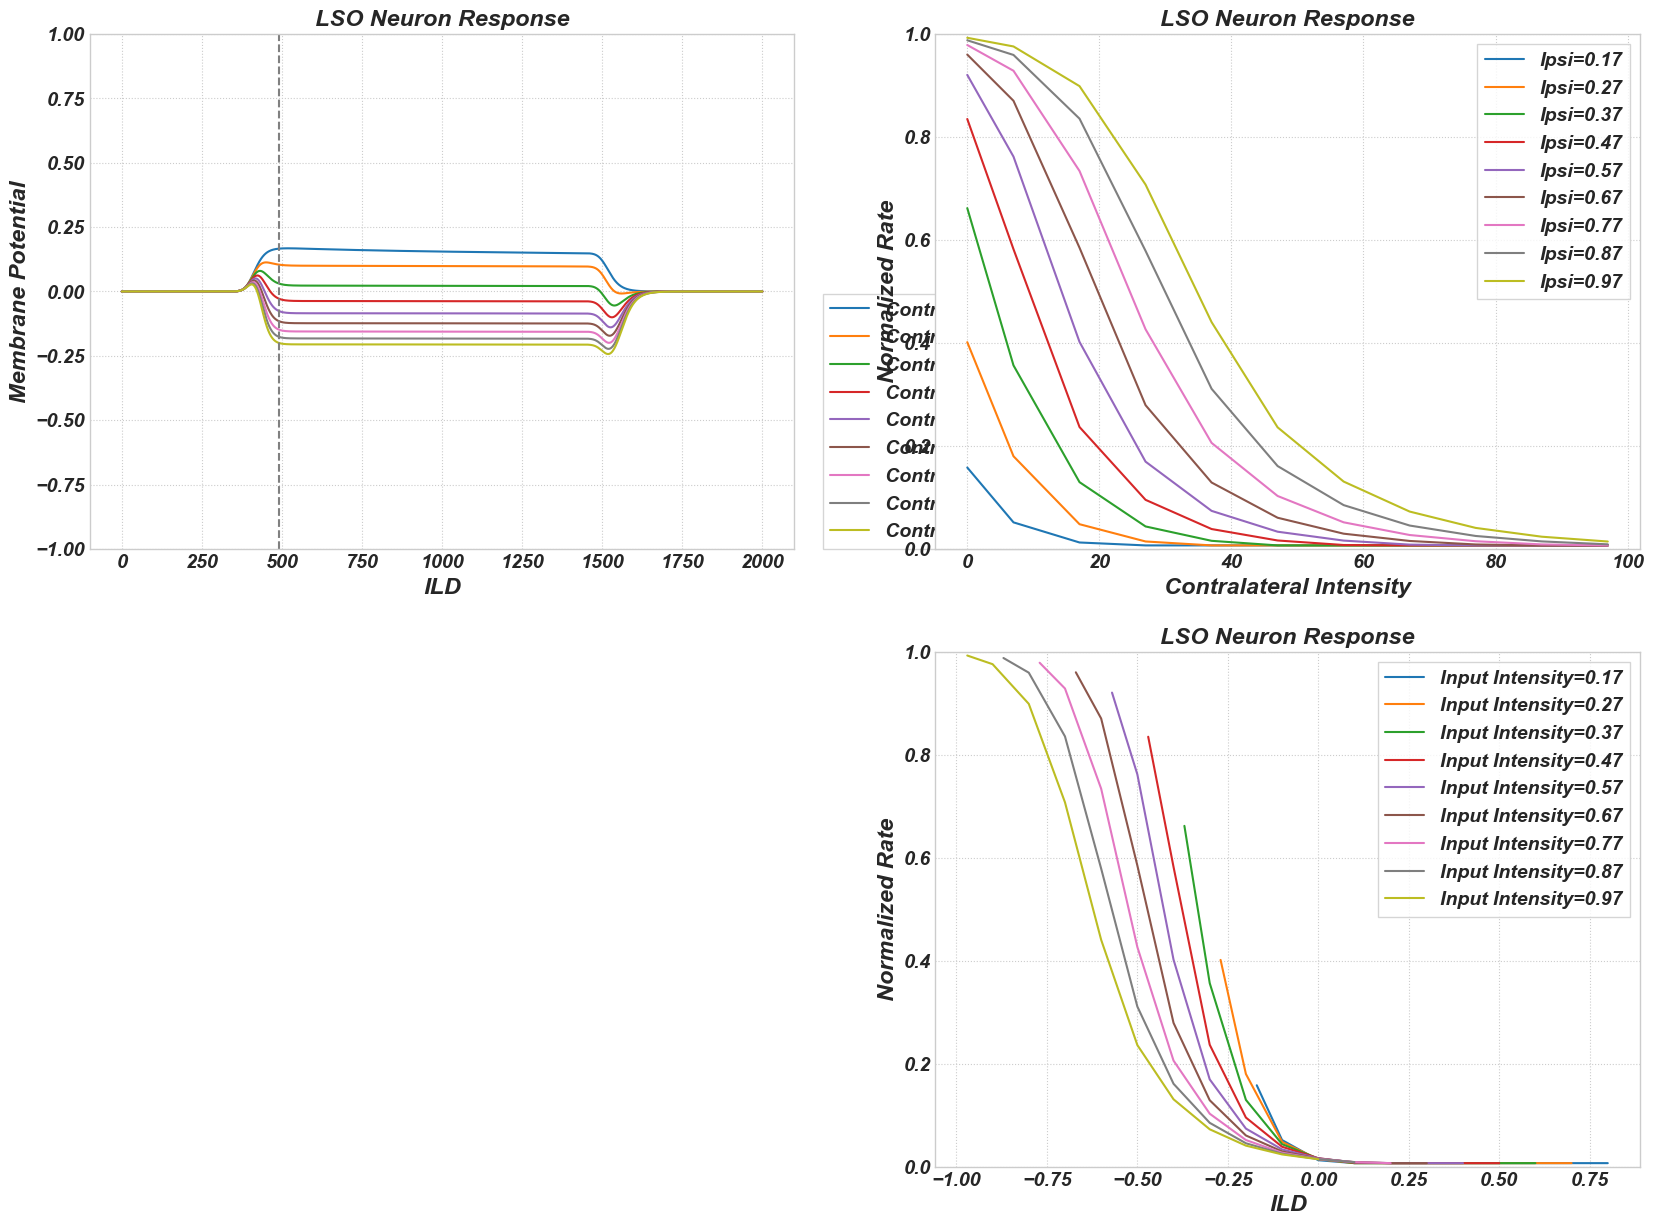

In [16]:
fig = plt.figure(figsize=(20,15))

# stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
# plt.suptitle(stri,fontsize=16)

# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
# plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
# plt.title('Input to Network')
# plt.legend()

# fig = plt.figure(figsize=(20,15))

# q = q_all[:,:,3]
# ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(q[i,:],label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
# plt.title('MNTB Neuron Response')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])
# plt.legend()

# ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(g_q_out(q[i,:]),label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
# plt.title('MNTB Neuron Response')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])
# plt.legend()

probing_time = [490]

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all

diff_input = diff_input[:,3]
r = r_all[:,:,:,3]
p = r_all[:,:,:,3]
ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(p[0,i,:],label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
    
for i in probing_time:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
lgd = plt.legend(loc=(1.04,0))
## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
for i in range(len(sbc_input_intensities)):
    plt.plot((gbc_input_intensities*100),np.squeeze(g_r_out(r[i,:,probing_time])),label='Ipsi={0:.2f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('Contralateral Intensity')
plt.ylabel('Normalized Rate')
plt.ylim([0,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
for i in range(len(sbc_input_intensities)):
    plt.plot((gbc_input_intensities-sbc_input_intensities[i]),np.squeeze(g_r_out(r[i,:,probing_time])),label='Input Intensity={0:.2f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Normalized Rate')
plt.ylim([0,1])
plt.legend()


plt.show()



The difference in the shape of the response curve comes from the fact that we do not have level differences above 0.57dB for that exsperiment

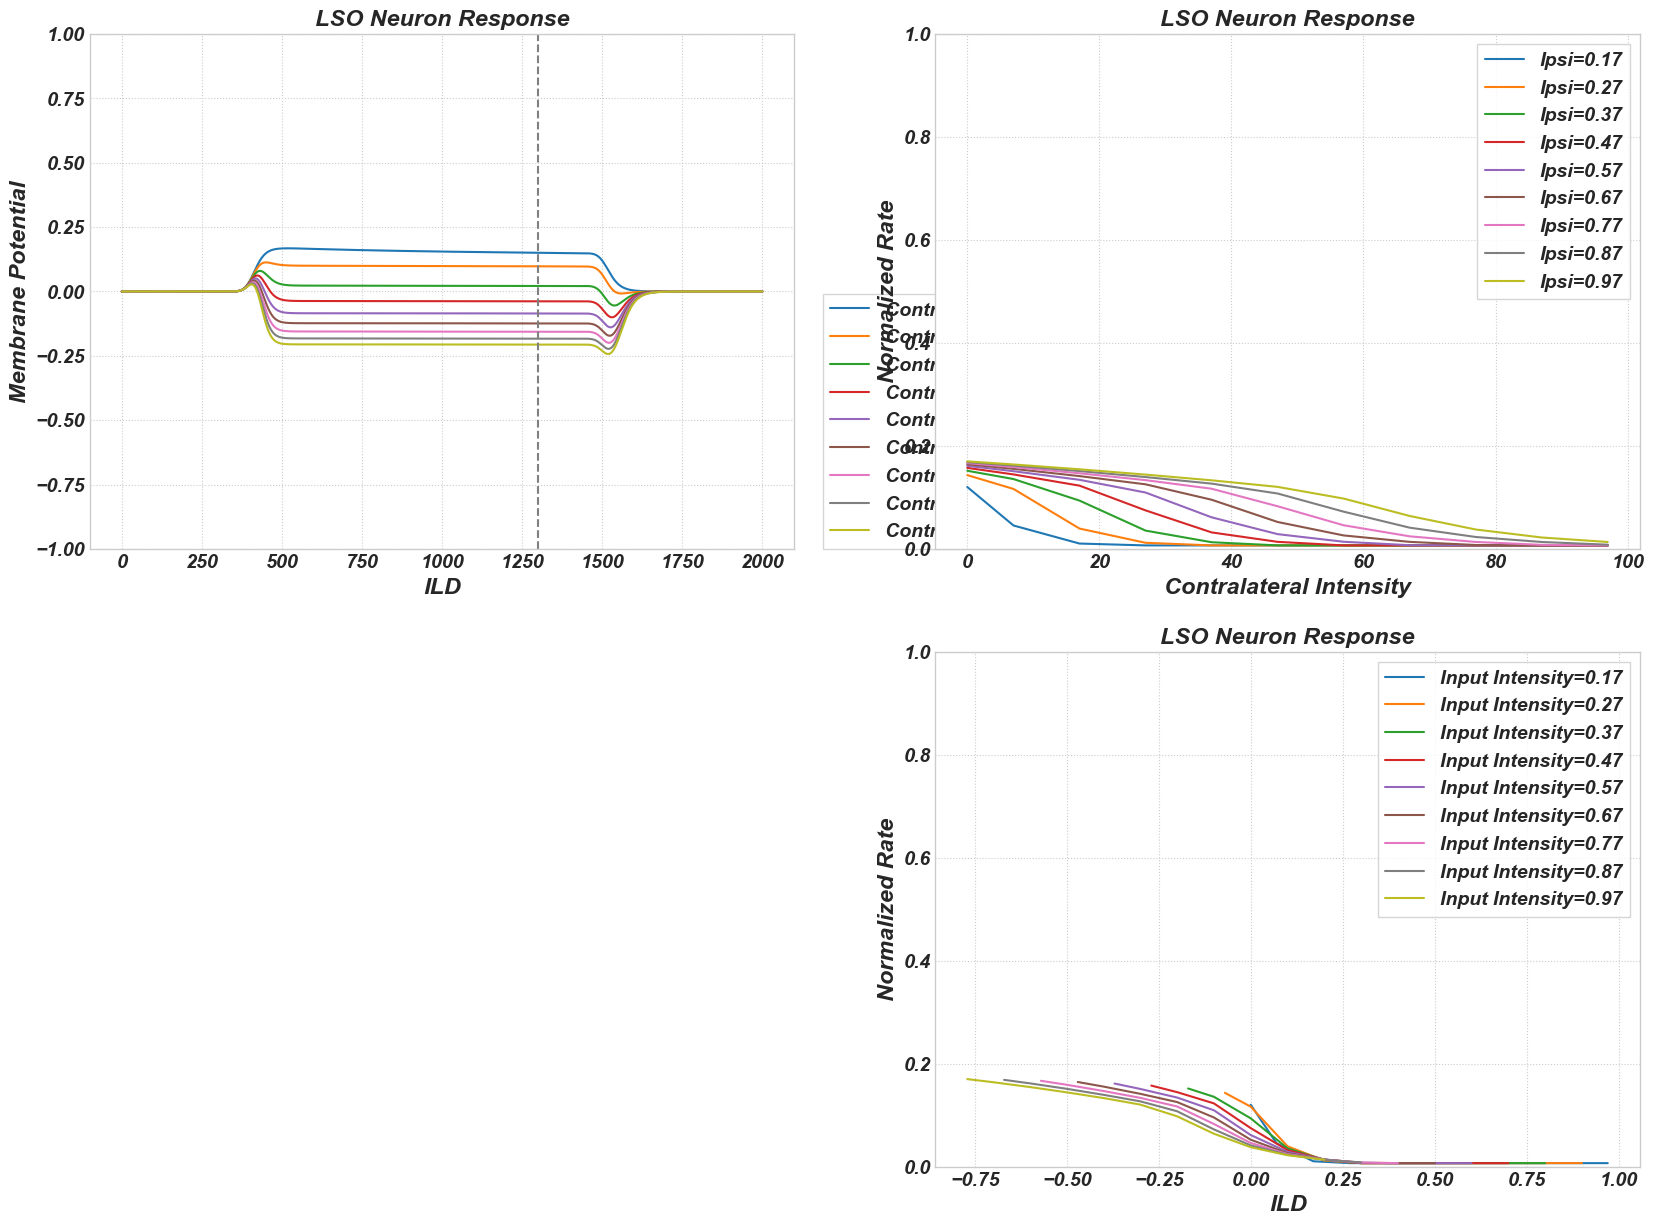

In [17]:
fig = plt.figure(figsize=(20,15))

# stri = 'gamma_r = '+str(gamma_r)+' kappa_r = '+str(kappa_r)+' gamma_q = '+str(gamma_q)+' kappa_q = '+str(kappa_q)
# plt.suptitle(stri,fontsize=16)

# ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
# plt.plot(s_sbc_all[:,3],'blue',  label='LSO Input')
# plt.plot(s_gbc_all[:,3],'red',  label='MNTB Input')
# plt.title('Input to Network')
# plt.legend()

# fig = plt.figure(figsize=(20,15))

# q = q_all[:,:,3]
# ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(q[i,:],label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
# plt.title('MNTB Neuron Response')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])
# plt.legend()

# ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
# for i in range(0,r.shape[0]):
#     plt.plot(g_q_out(q[i,:]),label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
# plt.title('MNTB Neuron Response')
# plt.xlabel('Time')
# plt.ylabel('Membrane Potential')
# plt.ylim([-1,1])
# plt.legend()

probing_time = [1300]

# show LSO neuron membrane
diff_input =  s_sbc_all-s_gbc_all

diff_input = diff_input[:,3]
r = r_all[:,:,:,3]
p = r_all[:,:,:,3]
ax2 = plt.subplot2grid((2, 2), (0, 0), rowspan=1)
for i in range(0,r.shape[0]):
    plt.plot(p[0,i,:],label='Contralateral Intensity = {0:.2f}'.format(gbc_input_intensities[i]))
    
for i in probing_time:
    plt.axvline(x=i,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Membrane Potential')
plt.ylim([-1,1])
lgd = plt.legend(loc=(1.04,0))
## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (0, 1), rowspan=1)
for i in range(len(sbc_input_intensities)):
    plt.plot((gbc_input_intensities*100),np.squeeze(g_r_out(r[i,:,probing_time])),label='Ipsi={0:.2f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('Contralateral Intensity')
plt.ylabel('Normalized Rate')
plt.ylim([0,1])
plt.legend()

## show LSO neuron response
ax2 = plt.subplot2grid((2, 2), (1, 1), rowspan=1)
for i in range(len(sbc_input_intensities)):
    plt.plot((gbc_input_intensities-gbc_input_intensities[i]),np.squeeze(g_r_out(r[i,:,probing_time])),label='Input Intensity={0:.2f}'.format(sbc_input_intensities[i]))
# plt.axvline(x=0.0,linestyle='--',color='grey')
# plt.axhline(y=0.5,linestyle='--',color='grey')
plt.title('LSO Neuron Response')
plt.xlabel('ILD')
plt.ylabel('Normalized Rate')
plt.ylim([0,1])
plt.legend()

plt.show()

Here we show the reponse after time x of the stimuli onset. Due to the inhibitiory GABA feedback the response decrease. However that is contradictive to  the findings of Park et al. 1997 where they describe that the spike count increases with stimuli duration (Fig.2). They measured neurons in bats, which could indicate that bats (non-mammals) do not have the inhibitory feedback connection.